In [8]:
# ==========================================
# 1. 환경 설정 및 경로 지정
# ==========================================
import sys
import os
from google.colab import drive

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

PROJECT_PATH = '/content/drive/MyDrive/DL_Project'
os.chdir(PROJECT_PATH)
sys.path.append(PROJECT_PATH)

try:
    from common.np import *
    from common.time_layers import TimeEmbedding, TimeLSTM, TimeDropout
    from common.layers import Affine, SoftmaxWithLoss, Softmax
    from common.optimizer import Adam
    from utils import extract_utterances
    import pandas as pd
    from collections import Counter
    print("✅ 라이브러리 로드 성공. 사용 모듈:", np.__name__)
except ImportError as e:
    print(f"❌ 라이브러리 로드 실패: {e}")

# ==========================================
# 2. 데이터 전처리 및 로더 (기존과 동일)
# ==========================================
def load_vocab(train_csv, max_vocab=4000):
    df = pd.read_csv(train_csv)
    words = []
    print("⏳ Vocab 생성 중...")
    for _, row in df.iterrows():
        try:
            utts = extract_utterances(row['filename'], ['CHI'])
            text = " ".join([u.clean_text for u in utts]).lower()
            words.extend(text.split())
        except: continue
    counter = Counter(words)
    most_common = counter.most_common(max_vocab)
    vocab = {'<pad>': 0, '<unk>': 1}
    for i, (w, _) in enumerate(most_common):
        vocab[w] = i + 2
    print(f"✅ Vocab 크기: {len(vocab)}")
    return vocab

def load_data(csv_path, vocab, max_len=300):
    df = pd.read_csv(csv_path)
    x_data, t_data = [], []
    label_map = {'TD': 0, 'SLI': 1}
    print(f"📂 데이터 로딩: {csv_path}")
    for _, row in df.iterrows():
        try:
            utts = extract_utterances(row['filename'], ['CHI'])
            if not utts: continue
            text = " ".join([u.clean_text for u in utts]).lower()
            tokens = text.split()
            ids = [vocab.get(w, vocab['<unk>']) for w in tokens]
            if len(ids) > max_len: ids = ids[:max_len]
            padded_ids = np.zeros(max_len, dtype=int)
            length = min(len(ids), max_len)
            padded_ids[:length] = ids[:length]
            x_data.append(padded_ids)
            t_data.append(label_map[row['group']])
        except: pass
    return np.array(x_data), np.array(t_data)

# ==========================================
# 3. Attention 계층 구현
# ==========================================
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weights = None
        self.cache = None

    def forward(self, hs, h):
        """
        hs: 모든 시점의 은닉 상태 (N, T, H) - Encoder Output
        h:  마지막 시점의 은닉 상태 (N, H) - Query
        """
        N, T, H = hs.shape

        # 1. 점수(Score) 계산: hs와 h의 내적 (유사도)
        hr = h.reshape(N, 1, H) # 브로드캐스팅을 위해 형상 변환
        t = np.sum(hs * hr, axis=2) # (N, T) - 각 시점별 유사도 점수

        # 2. 가중치(Weight) 계산: Softmax
        # (Softmax 구현: exp(x - max) / sum(exp))
        t = t - np.max(t, axis=1, keepdims=True) # 오버플로 방지
        exp_t = np.exp(t)
        a = exp_t / np.sum(exp_t, axis=1, keepdims=True) # (N, T) - 어텐션 가중치
        self.attention_weights = a

        # 3. 맥락 벡터(Context Vector) 계산: 가중합
        ar = a.reshape(N, T, 1)
        c = np.sum(hs * ar, axis=1) # (N, H)

        self.cache = (hs, hr, a)
        return c

    def backward(self, dc):
        hs, hr, a = self.cache
        N, T, H = hs.shape

        # 3. 가중합 역전파
        ar = a.reshape(N, T, 1)
        d_hs = dc.reshape(N, 1, H) * ar # (N, T, H)
        da = np.sum(dc.reshape(N, 1, H) * hs, axis=2) # (N, T)

        # 2. Softmax 역전파
        dt = a * (da - np.sum(da * a, axis=1, keepdims=True)) # (N, T)

        # 1. 내적 역전파
        d_hs += dt.reshape(N, T, 1) * hr
        d_hr = np.sum(dt.reshape(N, T, 1) * hs, axis=1) # (N, 1, H)
        dh = d_hr.reshape(N, H)

        return d_hs, dh

# ==========================================
# 4. Attention Classifier 모델 정의
# ==========================================
# 필요한 레이어 추가 임포트
from common.layers import Affine, SoftmaxWithLoss, Sigmoid, Dropout

class AttentionClassifier:
    def __init__(self, vocab_size, wordvec_size, hidden_size, class_size=2, dropout_ratio=0.5):
        V, D, H, C = vocab_size, wordvec_size, hidden_size, class_size
        rn = np.random.randn

        # 1. 가중치 초기화 (Encoder & Attention)
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        # 2. 가중치 초기화 (MLP Classifier Head) [이 부분이 빠져서 에러가 났습니다]
        # affine1: 입력(2H) -> 은닉(H)
        W1 = (rn(2 * H, H) / np.sqrt(2 * H)).astype('f')
        b1 = np.zeros(H).astype('f')
        # affine2: 은닉(H) -> 출력(C)
        W2 = (rn(H, C) / np.sqrt(H)).astype('f')
        b2 = np.zeros(C).astype('f')

        # 3. 계층 생성
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        self.attention = Attention()
        self.dropout1 = TimeDropout(dropout_ratio) # LSTM용 (3D)

        # MLP Head 계층
        self.affine1 = Affine(W1, b1)
        self.activation = Sigmoid()        # Tanh 대신 Sigmoid 사용 (라이브러리 호환성)
        self.dropout2 = Dropout(dropout_ratio) # 분류기용 (2D) - TimeDropout 아님!
        self.affine2 = Affine(W2, b2)

        self.loss_layer = SoftmaxWithLoss()

        # 4. 파라미터 수집
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine1, self.affine2):
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        # 1. Embedding & LSTM
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        hs = self.dropout1.forward(hs)

        # 2. Attention
        h_last = hs[:, -1, :]
        c = self.attention.forward(hs, h_last)

        # 3. Concat
        out = np.concatenate((c, h_last), axis=1) # (N, 2H)

        # 4. MLP Classifier Head (비선형 변환)
        out = self.affine1.forward(out)       # Linear
        out = self.activation.forward(out)    # Activation
        out = self.dropout2.forward(out)      # Dropout
        score = self.affine2.forward(out)     # Linear

        return score

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)

        # MLP Head Backward
        dout = self.affine2.backward(dout)
        dout = self.dropout2.backward(dout)
        dout = self.activation.backward(dout)
        dout = self.affine1.backward(dout)

        # Split gradients
        N, H2 = dout.shape
        H = H2 // 2
        dc, dh_last = dout[:, :H], dout[:, H:]

        # Attention Backward
        d_hs_att, dh_att = self.attention.backward(dc)

        # Combine gradients
        dhs = d_hs_att
        dhs[:, -1, :] += (dh_last + dh_att)

        dhs = self.dropout1.backward(dhs)
        dhs = self.lstm.backward(dhs)
        self.embed.backward(dhs)
        return None

    def set_train_flg(self, train_flg=True):
        self.dropout1.train_flg = train_flg
        self.dropout2.train_flg = train_flg # 일반 Dropout도 플래그 설정 필요

# ==========================================
# 5. 실행 (학습 루프)
# ==========================================
train_csv = 'split/gillam_train.csv'
dev_csv = 'split/gillam_dev.csv'
test_csv = 'split/gillam_test.csv'

vocab = load_vocab(train_csv, max_vocab=4000)
vocab_size = len(vocab)

x_train, t_train = load_data(train_csv, vocab)
x_dev, t_dev = load_data(dev_csv, vocab)
x_test, t_test = load_data(test_csv, vocab)

if np.__name__ == 'cupy':
    x_train, t_train = np.asarray(x_train), np.asarray(t_train)
    x_dev, t_dev = np.asarray(x_dev), np.asarray(t_dev)
    x_test, t_test = np.asarray(x_test), np.asarray(t_test)

# 하이퍼파라미터
max_epoch = 15
batch_size = 16
hidden_size = 128
wordvec_size = 100
dropout_ratio = 0.5
learning_rate = 0.001

model = AttentionClassifier(vocab_size, wordvec_size, hidden_size, dropout_ratio=dropout_ratio)
optimizer = Adam(lr=learning_rate)

data_size = len(x_train)
max_iters = data_size // batch_size

print(f"\n🚀 학습 시작 (Attention Mode | Device: {np.__name__})")

for epoch in range(max_epoch):
    model.set_train_flg(True)
    idx = np.random.permutation(data_size)
    x_train = x_train[idx]
    t_train = t_train[idx]

    total_loss = 0
    loss_count = 0

    for i in range(max_iters):
        batch_x = x_train[i*batch_size : (i+1)*batch_size]
        batch_t = t_train[i*batch_size : (i+1)*batch_size]

        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

    # 평가
    model.set_train_flg(False)
    model_score = model.predict(x_dev)
    pred = np.argmax(model_score, axis=1)
    acc = np.sum(pred == t_dev) / len(t_dev)

    avg_loss = total_loss / loss_count
    print(f"| Epoch {epoch+1:02} | Loss {avg_loss:.4f} | Dev Acc {acc:.4f}")

# 최종 테스트
model.set_train_flg(False)
test_score = model.predict(x_test)
test_pred = np.argmax(test_score, axis=1)
test_acc = np.sum(test_pred == t_test) / len(t_test)

print(f"\n🏆 Final Test Accuracy: {test_acc*100:.2f}%")

✅ 라이브러리 로드 성공. 사용 모듈: numpy
⏳ Vocab 생성 중...
✅ Vocab 크기: 3702
📂 데이터 로딩: split/gillam_train.csv
📂 데이터 로딩: split/gillam_dev.csv
📂 데이터 로딩: split/gillam_test.csv

🚀 학습 시작 (Attention Mode | Device: numpy)
| Epoch 01 | Loss 0.6015 | Dev Acc 0.7353
| Epoch 02 | Loss 0.5745 | Dev Acc 0.7206
| Epoch 03 | Loss 0.4855 | Dev Acc 0.7647
| Epoch 04 | Loss 0.4436 | Dev Acc 0.7206
| Epoch 05 | Loss 0.3461 | Dev Acc 0.7353
| Epoch 06 | Loss 0.4464 | Dev Acc 0.6618
| Epoch 07 | Loss 0.3273 | Dev Acc 0.7059
| Epoch 08 | Loss 0.3364 | Dev Acc 0.7059
| Epoch 09 | Loss 0.2369 | Dev Acc 0.8088
| Epoch 10 | Loss 0.2695 | Dev Acc 0.7206
| Epoch 11 | Loss 0.2548 | Dev Acc 0.8088
| Epoch 12 | Loss 0.1628 | Dev Acc 0.8088
| Epoch 13 | Loss 0.1376 | Dev Acc 0.6912
| Epoch 14 | Loss 0.2048 | Dev Acc 0.7794
| Epoch 15 | Loss 0.1402 | Dev Acc 0.7941

🏆 Final Test Accuracy: 79.41%


🔍 어텐션 시각화 예시 (Dev Set Sample)


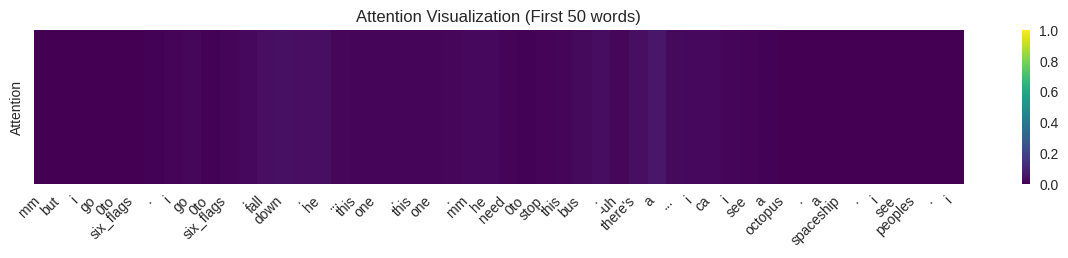


📊 Dev Set 오답 분석 중...

📊 Test Set 오답 분석 중...

총 오답 개수: 32 (Dev: 16, Test: 16)


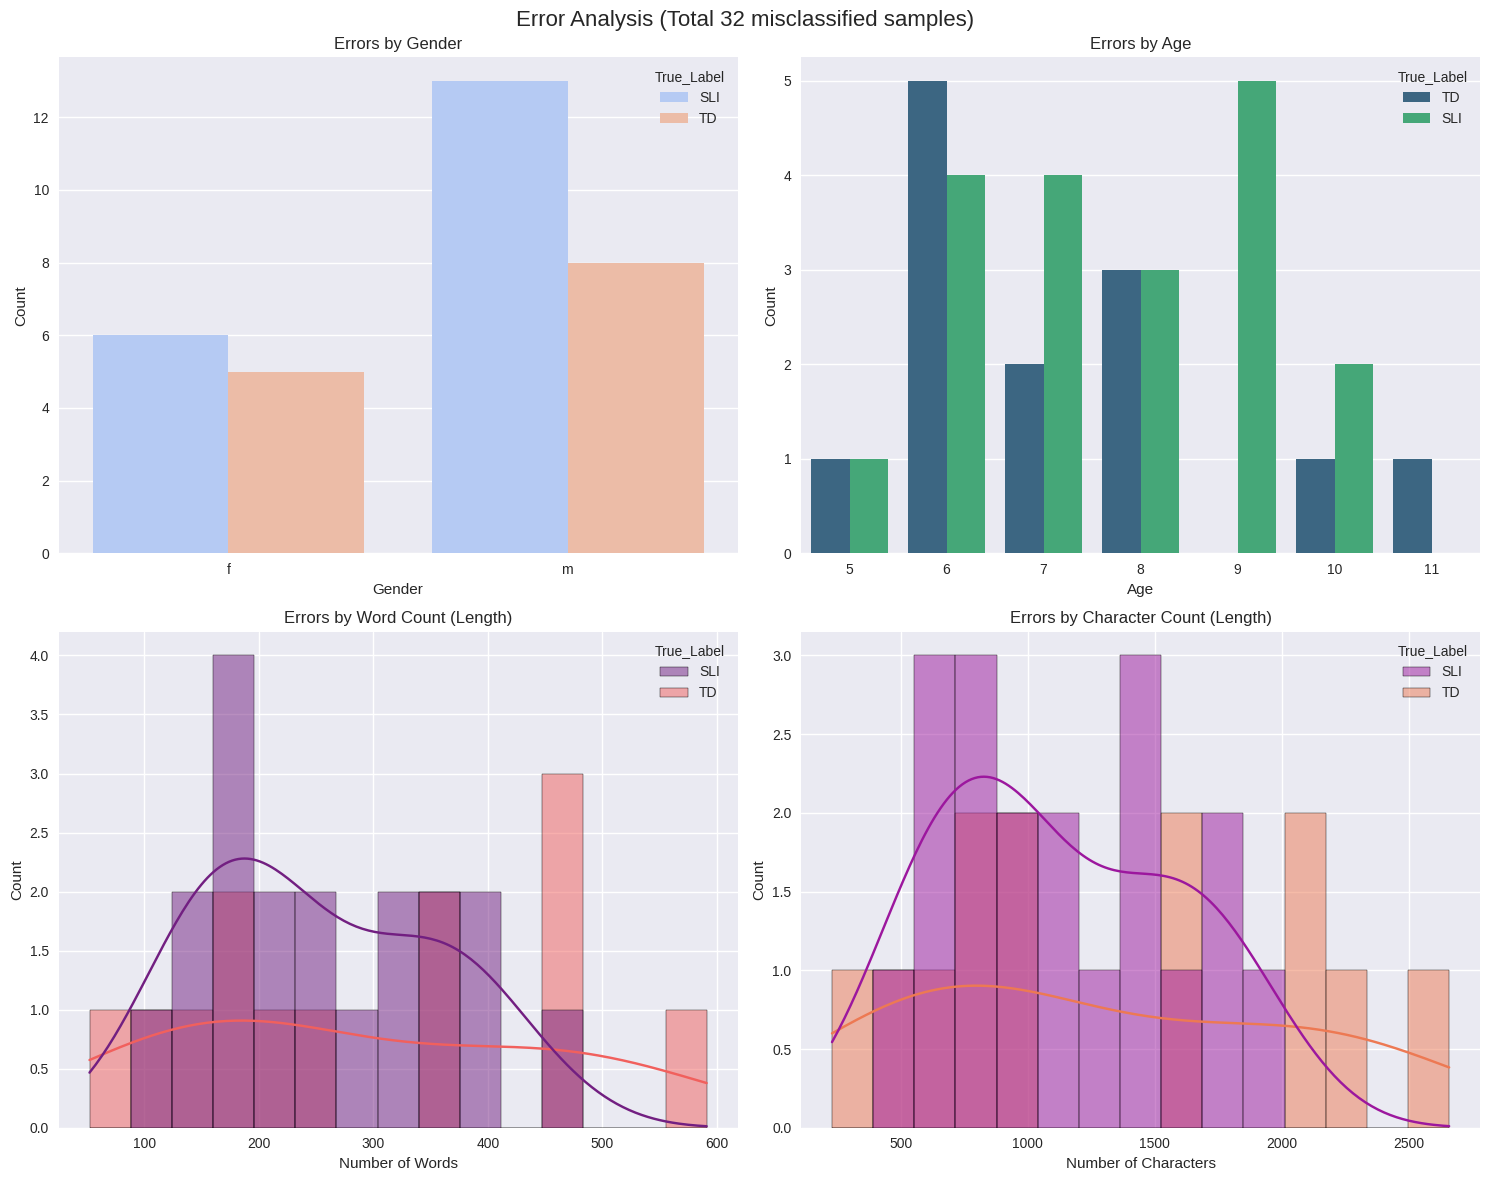


[상세 통계]

1. 성별 오답 수:
Gender
m    21
f    11
Name: count, dtype: int64

2. 연령별 오답 수:
Age
5     2
6     9
7     6
8     6
9     5
10    3
11    1
Name: count, dtype: int64

3. 평균 길이 통계 (오답 데이터):
       Word_Count   Char_Count
count   32.000000    32.000000
mean   269.718750  1196.531250
std    133.546714   610.499742
min     52.000000   230.000000
25%    174.500000   769.500000
50%    237.000000  1048.500000
75%    361.750000  1574.750000
max    591.000000  2659.000000


In [9]:
# ==========================================
# 1. 라이브러리 임포트
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from utils import extract_utterances

# 한글 폰트 설정 (코랩 환경용)
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# (위 주석을 풀고 한번 실행 후 런타임을 재시작하면 한글이 깨지지 않습니다.
#  여기서는 영문 라벨을 사용하여 에러 없이 출력되도록 하겠습니다.)

plt.style.use('seaborn-v0_8')

# ==========================================
# 2. 어텐션 시각화 함수
# ==========================================
def visualize_attention(model, text, vocab):
    """
    특정 텍스트를 입력받아 모델의 어텐션 가중치를 시각화
    """
    model.set_train_flg(False) # 평가 모드

    # 전처리
    tokens = text.lower().split()
    if len(tokens) == 0: return

    ids = [vocab.get(w, vocab['<unk>']) for w in tokens]
    x_in = np.array(ids).reshape(1, -1) # Batch size 1

    # 모델 실행 (Attention 가중치 계산됨)
    _ = model.predict(x_in)

    # 가중치 가져오기 (1, T)
    # Attention 클래스 구현에 따라 shape이 다를 수 있어 확인 필요
    # 앞서 구현한 코드 기준: self.attention.attention_weights (N, T)
    weights = model.attention.attention_weights[0]

    # 시각화
    # 길이가 너무 길면 잘라서 보여줌 (가독성)
    view_len = min(len(tokens), 50)

    plt.figure(figsize=(15, 2))
    sns.heatmap(weights[:view_len].reshape(1, -1),
                xticklabels=tokens[:view_len],
                yticklabels=['Attention'],
                cmap='viridis',
                cbar=True,
                vmin=0, vmax=1)
    plt.title(f"Attention Visualization (First {view_len} words)")
    plt.xticks(rotation=45, ha='right')
    plt.show()

# 테스트: Dev 셋의 첫 번째 데이터로 시각화 해보기
print("🔍 어텐션 시각화 예시 (Dev Set Sample)")
dev_df = pd.read_csv('split/gillam_dev.csv')
sample_row = dev_df.iloc[0]
try:
    utts = extract_utterances(sample_row['filename'], ['CHI'])
    sample_text = " ".join([u.clean_text for u in utts])
    visualize_attention(model, sample_text, vocab)
except Exception as e:
    print(f"시각화 실패: {e}")


# ==========================================
# 3. 오답 데이터 상세 분석 함수
# ==========================================
def analyze_errors(model, df, vocab, dataset_name="Dev"):
    error_records = []
    model.set_train_flg(False)

    label_map = {'TD': 0, 'SLI': 1}
    inv_label_map = {0: 'TD', 1: 'SLI'}

    print(f"\n📊 {dataset_name} Set 오답 분석 중...")

    for idx, row in df.iterrows():
        try:
            # 데이터 로드 및 전처리
            utts = extract_utterances(row['filename'], ['CHI'])
            if not utts: continue

            text = " ".join([u.clean_text for u in utts]).lower()
            tokens = text.split()

            ids = [vocab.get(w, vocab['<unk>']) for w in tokens]
            x_in = np.array(ids).reshape(1, -1)

            # 예측
            score = model.predict(x_in)
            pred_idx = np.argmax(score, axis=1)[0]
            true_idx = label_map[row['group']]

            # 틀린 경우 저장
            if pred_idx != true_idx:
                error_records.append({
                    'Index': idx,
                    'Gender': row['gender'],
                    'Age': row['age'],
                    'True_Label': row['group'],
                    'Pred_Label': inv_label_map[pred_idx],
                    'Word_Count': len(tokens),
                    'Char_Count': len(text),
                    'Text': text[:50] + "..." # 일부만 저장
                })

        except Exception as e:
            continue

    return pd.DataFrame(error_records)

# 분석 실행
dev_errors = analyze_errors(model, pd.read_csv('split/gillam_dev.csv'), vocab, "Dev")
test_errors = analyze_errors(model, pd.read_csv('split/gillam_test.csv'), vocab, "Test")

# 데이터 합치기 (전체 오답 경향 파악)
all_errors = pd.concat([dev_errors, test_errors])
print(f"\n총 오답 개수: {len(all_errors)} (Dev: {len(dev_errors)}, Test: {len(test_errors)})")

# ==========================================
# 4. 오답 통계 시각화
# ==========================================
if len(all_errors) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    plt.suptitle(f"Error Analysis (Total {len(all_errors)} misclassified samples)", fontsize=16)

    # 1. 성별 오답 수 (Gender)
    sns.countplot(data=all_errors, x='Gender', hue='True_Label', ax=axes[0, 0], palette='coolwarm')
    axes[0, 0].set_title("Errors by Gender")
    axes[0, 0].set_ylabel("Count")

    # 2. 연령별 오답 수 (Age)
    sns.countplot(data=all_errors, x='Age', hue='True_Label', ax=axes[0, 1], palette='viridis')
    axes[0, 1].set_title("Errors by Age")
    axes[0, 1].set_ylabel("Count")

    # 3. 단어 수에 따른 오답 분포 (Word Count Histogram)
    sns.histplot(data=all_errors, x='Word_Count', hue='True_Label', kde=True, bins=15, ax=axes[1, 0], palette='magma')
    axes[1, 0].set_title("Errors by Word Count (Length)")
    axes[1, 0].set_xlabel("Number of Words")

    # 4. 글자 수에 따른 오답 분포 (Char Count Histogram)
    sns.histplot(data=all_errors, x='Char_Count', hue='True_Label', kde=True, bins=15, ax=axes[1, 1], palette='plasma')
    axes[1, 1].set_title("Errors by Character Count (Length)")
    axes[1, 1].set_xlabel("Number of Characters")

    plt.tight_layout()
    plt.show()

    # 통계 테이블 출력
    print("\n[상세 통계]")
    print("\n1. 성별 오답 수:")
    print(all_errors['Gender'].value_counts())

    print("\n2. 연령별 오답 수:")
    print(all_errors['Age'].value_counts().sort_index())

    print("\n3. 평균 길이 통계 (오답 데이터):")
    print(all_errors[['Word_Count', 'Char_Count']].describe())

else:
    print("🎉 축하합니다! 오답 데이터가 없습니다 (또는 데이터를 로드하지 못했습니다).")